Optimal wing weights using py_vollib:
Wing Call weight (strike 105, T2): 0.1738
Wing Put weight (strike 95, T2): 0.1010


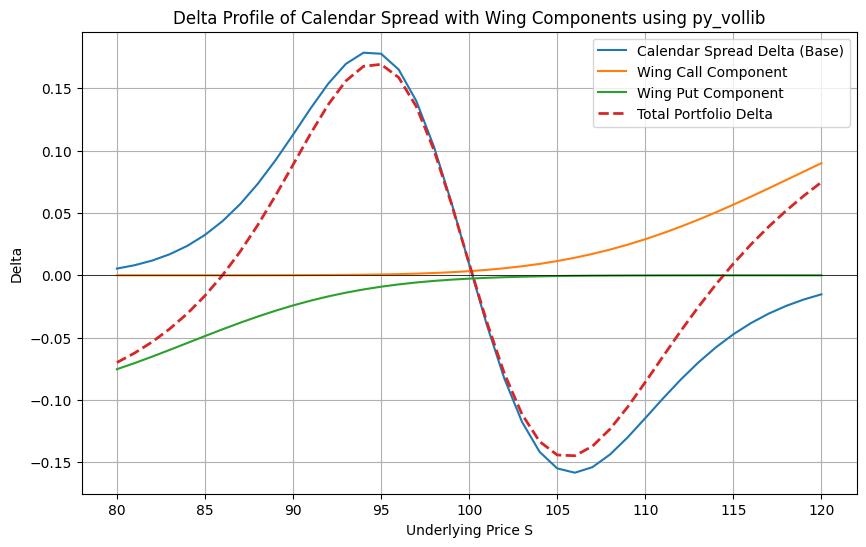

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from py_vollib.black_scholes.greeks.analytical import delta, gamma, theta, vega

# Option parameters
S0 = 100.0
K = 100.0           # ATM strike for calendar spread
sigma = 0.30        # 30% volatility (assumed constant for simplicity)
r = 0.0             # risk-free rate
T1 = 30/365         # longer expiry (e.g., 30 days)
T2 = 7/365          # shorter expiry (e.g., 7 days)

# Wing option strikes (using the same T2 expiry)
K_wing_call = 120 # OTM call
K_wing_put  = 85   # OTM put

# Create a grid of underlying prices (calibration points)
S = np.linspace(80, 120, 41)

# Compute deltas using py_vollib for each option leg
# For a call option: flag='c'; for a put option: flag='p'
delta_long_call_T1 = np.array([delta('c', s, K, T1, r, sigma) for s in S])
delta_short_call_T2 = np.array([delta('c', s, K, T2, r, sigma) for s in S])
delta_calendar = delta_long_call_T1 - delta_short_call_T2  # Calendar spread delta

# Wing option deltas (using T2 expiry for both)
delta_wing_call = np.array([delta('c', s, K_wing_call, T2, r, sigma) for s in S])
delta_wing_put  = np.array([delta('p', s, K_wing_put, T2, r, sigma) for s in S])

# Our portfolio delta is:
# Delta_portfolio(S) = delta_calendar(S) + w_call * delta_wing_call(S) + w_put * delta_wing_put(S)
# We want this to be ≈ 0 for all S in our grid.
# Formulate the problem in a least-squares sense:
#   X * [w_call, w_put]^T = -delta_calendar
X = np.vstack([delta_wing_call, delta_wing_put]).T  # Design matrix
y = -delta_calendar                                 # Target vector

# Solve the least squares problem to find the optimal weights
weights, residuals, rank, svals = np.linalg.lstsq(X, y, rcond=None)
w_call, w_put = weights

print("Optimal wing weights using py_vollib:")
print("Wing Call weight (strike 105, T2): {:.4f}".format(w_call))
print("Wing Put weight (strike 95, T2): {:.4f}".format(w_put))

# Compute the total portfolio delta using the optimal weights
portfolio_delta = delta_calendar + w_call * delta_wing_call + w_put * delta_wing_put

# Plot the individual deltas and the resulting portfolio delta
plt.figure(figsize=(10, 6))
plt.plot(S, delta_calendar, label='Calendar Spread Delta (Base)')
plt.plot(S, w_call * delta_wing_call, label='Wing Call Component')
plt.plot(S, w_put * delta_wing_put, label='Wing Put Component')
plt.plot(S, portfolio_delta, label='Total Portfolio Delta', linestyle='--', linewidth=2)
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel('Underlying Price S')
plt.ylabel('Delta')
plt.title('Delta Profile of Calendar Spread with Wing Components using py_vollib')
plt.legend()
plt.grid(True)
plt.show()


0.5775999999999999
0.6189
Net Gamma of the Diagonal Spread: 0.050966
Net Theta of the Diagonal Spread: 0.249945


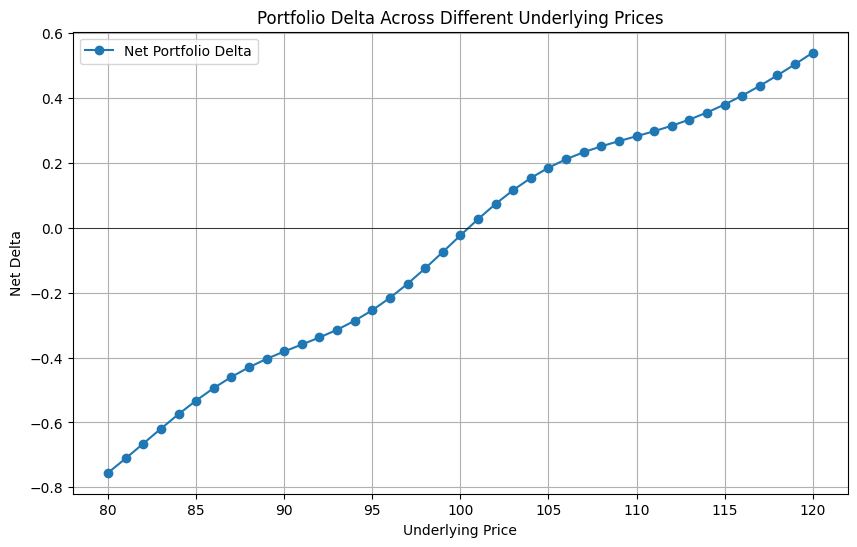

In [35]:
import numpy as np 
import matplotlib.pyplot as plt
from py_vollib.black_scholes.greeks.analytical import delta, gamma, theta

def adjusted_vol(atm_vol, strike, atm_strike, skew, kurtosis):
    """
    Compute the adjusted implied volatility for a given strike.
    
    Parameters:
      atm_vol   : Base volatility at ATM (e.g., 60)
      strike    : Strike price of the option
      atm_strike: The ATM strike price
      skew      : Skew parameter (linear adjustment)
      kurtosis  : Kurtosis parameter (quadratic adjustment)
    
    Returns:
      Adjusted volatility for the given strike.
    """
    m = strike / atm_strike  # relative strike ratio
    return atm_vol + (m - 1) * skew + (m**2 - 1) * kurtosis

skew = -.2
kurtosis = .04
# Parameters
r = 0.0                    # Risk-free rate
sigma_short = 0.60         # Implied volatility for front expiry (elevated)
sigma_long = 0.3          # Implied volatility for back expiry
T_long = 14/365            # Longer expiry (14 days)
T_short = 7/365            # Shorter expiry (7 days)

# Strike prices for the main options
strike_long = 100.0        # Long call strike for back month
strike_short = 100.0       # Short call strike for front month

# Wing option strikes
wing_call_strike = 120.0   # Wing call strike
wing_put_strike = 85.0     # Wing put strike

# Calculate gamma and theta (for reference)
S_ref = 100.0  # reference underlying price for reporting gamma/theta
gamma_long = gamma('c', S_ref, strike_long, T_long, r, sigma_long)
gamma_short = gamma('c', S_ref, strike_short, T_short, r, sigma_short)
wing_call_gamma = gamma('c', S_ref, wing_call_strike, T_short, r, adjusted_vol(sigma_short, wing_call_strike, S_ref, skew, kurtosis))
wing_put_gamma = gamma('p', S_ref, wing_put_strike, T_short, r, adjusted_vol(sigma_short, wing_put_strike, S_ref, skew, kurtosis))

theta_long = theta('c', S_ref, strike_long, T_long, r, sigma_long)
theta_short = theta('c', S_ref, strike_short, T_short, r, sigma_short)
wing_call_theta = theta('c', S_ref, wing_call_strike, T_short, r, adjusted_vol(sigma_short, wing_call_strike, S_ref, skew, kurtosis))
wing_put_theta = theta('p', S_ref, wing_put_strike, T_short, r, adjusted_vol(sigma_short, wing_put_strike, S_ref, skew, kurtosis))

# Construct net Greeks for the portfolio (as provided)
net_gamma = 2 * gamma_long - 2 * gamma_short + wing_call_gamma + wing_put_gamma
net_theta = 2 * theta_long - 2 * theta_short + wing_call_theta + wing_put_theta

print(adjusted_vol(sigma_short, wing_call_strike, S_ref, skew, kurtosis))
print(adjusted_vol(sigma_short, wing_put_strike, S_ref, skew, kurtosis))
print("Net Gamma of the Diagonal Spread: {:.6f}".format(net_gamma))
print("Net Theta of the Diagonal Spread: {:.6f}".format(net_theta))

# Now, calculate the delta across a range of underlying prices
S_values = np.linspace(80, 120, 41)  # Underlying prices from 80 to 120

# Compute delta for each leg of the portfolio over the S grid:
# For calls, delta is positive; for puts, delta is negative.
delta_long = np.array([delta('c', S, strike_long, T_long, r, sigma_long) for S in S_values])
delta_short = np.array([delta('c', S, strike_short, T_short, r, sigma_short) for S in S_values])
delta_wing_call = np.array([delta('c', S, wing_call_strike, T_short, r,adjusted_vol(sigma_short, wing_call_strike, S_ref, skew, kurtosis)) for S in S_values])
delta_wing_put = np.array([delta('p', S, wing_put_strike, T_short, r, adjusted_vol(sigma_short, wing_put_strike, S_ref, skew, kurtosis)) for S in S_values])

# Construct net portfolio delta:
# Long 2 back-month calls, short 2 front-month calls, plus long 1 wing call and long 1 wing put.
net_delta = 2 * delta_long - 2 * delta_short + delta_wing_call + delta_wing_put

# Plot the net portfolio delta across different underlying prices
plt.figure(figsize=(10,6))
plt.plot(S_values, net_delta, label='Net Portfolio Delta', marker='o')
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel("Underlying Price")
plt.ylabel("Net Delta")
plt.title("Portfolio Delta Across Different Underlying Prices")
plt.legend()
plt.grid(True)
plt.show()


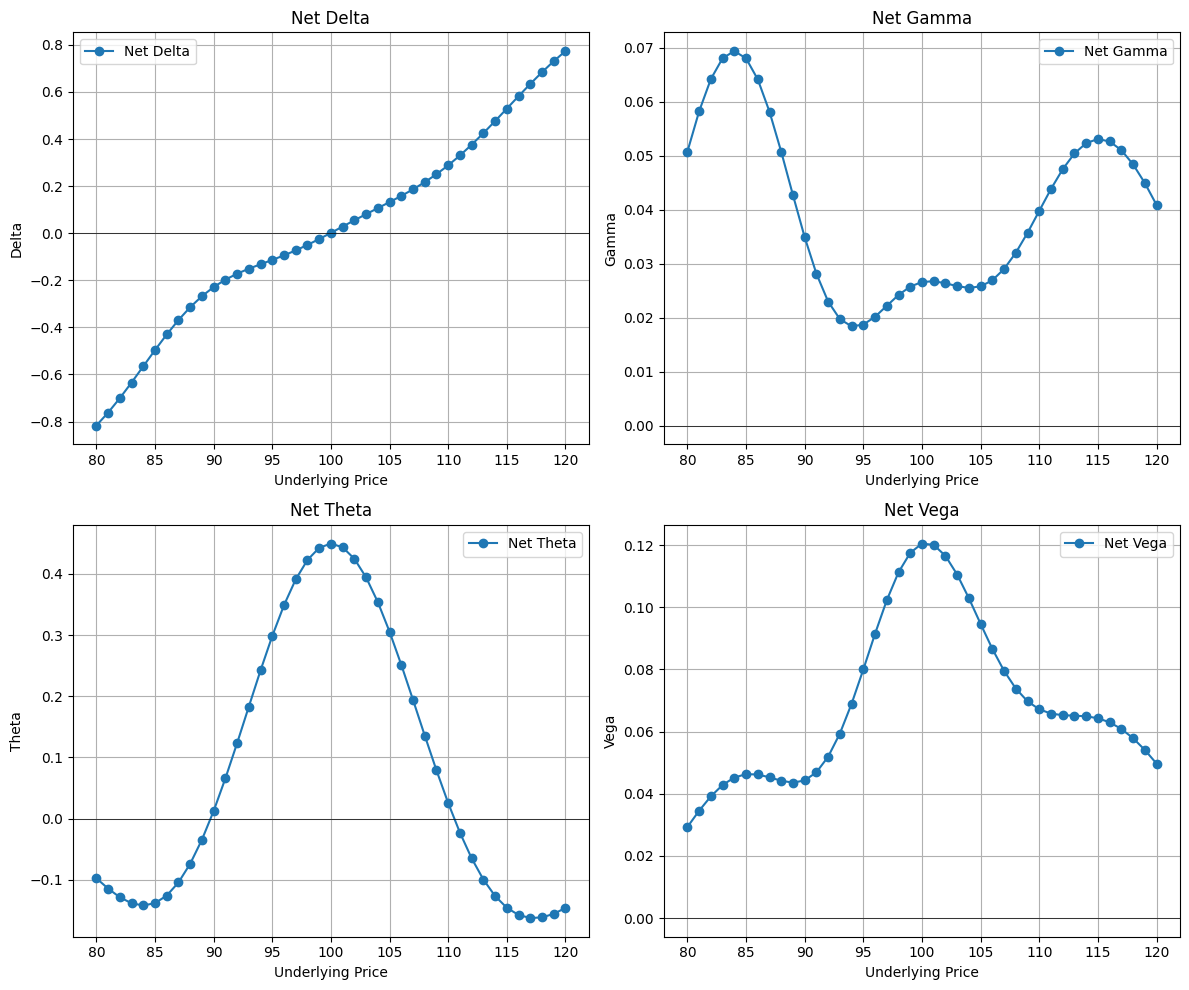

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from py_vollib.black_scholes.greeks.analytical import delta, gamma, theta, vega

def adjusted_vol(atm_vol, strike, atm_strike, skew, kurtosis):
    """
    Compute the adjusted implied volatility for a given strike.
    
    Parameters:
      atm_vol   : Base volatility at ATM (e.g., 60)
      strike    : Strike price of the option
      atm_strike: The ATM strike price
      skew      : Skew parameter (linear adjustment)
      kurtosis  : Kurtosis parameter (quadratic adjustment)
    
    Returns:
      Adjusted volatility for the given strike.
    """
    m = strike / atm_strike  # relative strike ratio
    return atm_vol + (m - 1) * skew + (m**2 - 1) * kurtosis

def compute_portfolio_greeks(S_values, 
                             strike_long, T_long, sigma_long,
                             strike_short, T_short, sigma_short,
                             wing_call_strike, wing_put_strike,
                             r, S_ref, skew, kurtosis):
    """
    Compute the net delta, gamma, theta and vega for the portfolio across a range of underlying prices.
    
    Portfolio construction:
      - Long 2 back-month calls (strike_long, T_long, sigma_long)
      - Short 2 front-month calls (strike_short, T_short, sigma_short)
      - Long 1 wing call (wing_call_strike, T_short, vol adjusted using skew & kurtosis)
      - Long 1 wing put  (wing_put_strike, T_short, vol adjusted using skew & kurtosis)
    """
    # Adjusted volatilities for the wings
    sigma_wing_call = adjusted_vol(sigma_short, wing_call_strike, S_ref, skew, kurtosis)
    sigma_wing_put  = adjusted_vol(sigma_short, wing_put_strike, S_ref, skew, kurtosis)
    
    # Compute delta for each leg
    long_delta = np.array([delta('c', S, strike_long, T_long, r, sigma_long) for S in S_values])
    short_delta = np.array([delta('c', S, strike_short, T_short, r, sigma_short) for S in S_values])
    wing_call_delta = np.array([delta('c', S, wing_call_strike, T_short, r, sigma_wing_call) for S in S_values])
    wing_put_delta = np.array([delta('p', S, wing_put_strike, T_short, r, sigma_wing_put) for S in S_values])
    net_delta = 5 * long_delta - 5 * short_delta + wing_call_delta + wing_put_delta

    # Compute gamma for each leg
    long_gamma = np.array([gamma('c', S, strike_long, T_long, r, sigma_long) for S in S_values])
    short_gamma = np.array([gamma('c', S, strike_short, T_short, r, sigma_short) for S in S_values])
    wing_call_gamma = np.array([gamma('c', S, wing_call_strike, T_short, r, sigma_wing_call) for S in S_values])
    wing_put_gamma = np.array([gamma('p', S, wing_put_strike, T_short, r, sigma_wing_put) for S in S_values])
    net_gamma = 5 * long_gamma - 5 * short_gamma + wing_call_gamma + wing_put_gamma

    # Compute theta for each leg
    long_theta = np.array([theta('c', S, strike_long, T_long, r, sigma_long) for S in S_values])
    short_theta = np.array([theta('c', S, strike_short, T_short, r, sigma_short) for S in S_values])
    wing_call_theta = np.array([theta('c', S, wing_call_strike, T_short, r, sigma_wing_call) for S in S_values])
    wing_put_theta = np.array([theta('p', S, wing_put_strike, T_short, r, sigma_wing_put) for S in S_values])
    # Note: For a short option, theta contributes with the opposite sign.
    net_theta = 5 * long_theta - 5 * short_theta + wing_call_theta + wing_put_theta

    # Compute vega for each leg
    long_vega = np.array([vega('c', S, strike_long, T_long, r, sigma_long) for S in S_values])
    short_vega = np.array([vega('c', S, strike_short, T_short, r, sigma_short) for S in S_values])
    wing_call_vega = np.array([vega('c', S, wing_call_strike, T_short, r, sigma_wing_call) for S in S_values])
    wing_put_vega = np.array([vega('p', S, wing_put_strike, T_short, r, sigma_wing_put) for S in S_values])
    net_vega = 5 * long_vega - 5 * short_vega + wing_call_vega + wing_put_vega
    
    return net_delta, net_gamma, net_theta, net_vega

# Parameters
r = 0.0
S_ref = 100.0       # Reference underlying price (ATM)
strike_long = 100.0 # Back-month call strike
T_long = 14/365     # Back-month expiry (14 days)
sigma_long = 0.3    # Back-month vol
strike_short = 100.0  # Front-month call strike
T_short = 7/365       # Front-month expiry (7 days)
sigma_short = 0.45    # Front-month vol (elevated)
wing_call_strike = 85.0  # Wing call strike (OTM)
wing_put_strike = 115.0    # Wing put strike (OTM)

# Skew and kurtosis parameters for the vol surface adjustment:
skew = -0.2      # linear adjustment (e.g. -0.2)
kurtosis = 0.04  # quadratic adjustment (e.g. 0.04)

# Underlying price grid
S_values = np.linspace(80, 120, 41)

# Calculate net portfolio Greeks
net_delta, net_gamma, net_theta, net_vega = compute_portfolio_greeks(
    S_values,
    strike_long, T_long, sigma_long,
    strike_short, T_short, sigma_short,
    wing_call_strike, wing_put_strike,
    r, S_ref, skew, kurtosis
)

# Plot the net Greeks across underlying prices
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.plot(S_values, net_delta, marker='o', label="Net Delta")
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel("Underlying Price")
plt.ylabel("Delta")
plt.title("Net Delta")
plt.legend()
plt.grid(True)

plt.subplot(2,2,2)
plt.plot(S_values, net_gamma, marker='o', label="Net Gamma")
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel("Underlying Price")
plt.ylabel("Gamma")
plt.title("Net Gamma")
plt.legend()
plt.grid(True)

plt.subplot(2,2,3)
plt.plot(S_values, net_theta, marker='o', label="Net Theta")
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel("Underlying Price")
plt.ylabel("Theta")
plt.title("Net Theta")
plt.legend()
plt.grid(True)

plt.subplot(2,2,4)
plt.plot(S_values, net_vega, marker='o', label="Net Vega")
plt.axhline(0, color='black', linewidth=0.5)
plt.xlabel("Underlying Price")
plt.ylabel("Vega")
plt.title("Net Vega")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
